In [188]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['plates']


In [189]:
data_root = '../input/plates/plates/'
print(os.listdir(data_root))

['test', 'train']


In [190]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))



  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 971.61it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 1426.46it/s]

In [191]:
!ls train

cleaned  dirty


In [192]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.CenterCrop(224), #changed RandomCrop
    #transforms.RandomCrop(224),
    transforms.RandomRotation(60),  # new
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), # new
    transforms.RandomAffine(0.02), # new
    transforms.ColorJitter(saturation = 4, hue=0), # new
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [193]:
len(train_dataloader), len(train_dataset)

(4, 32)

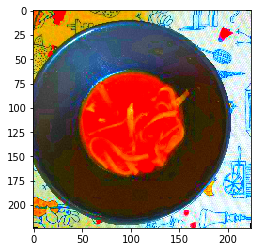

In [194]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

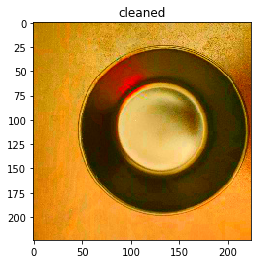

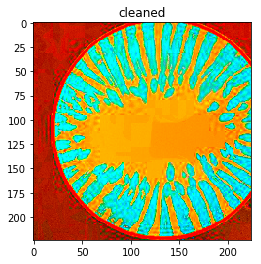

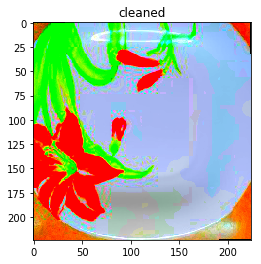

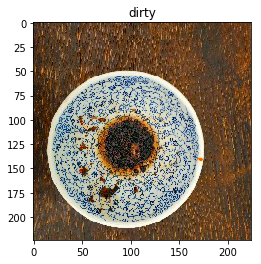

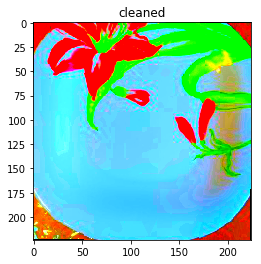

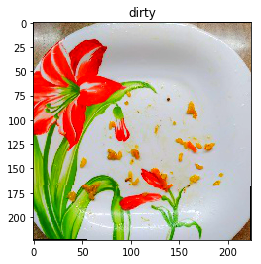

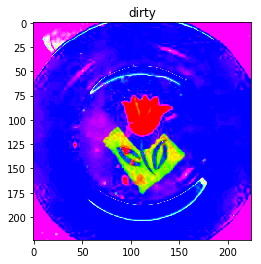

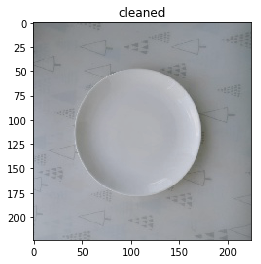

In [195]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [196]:
num_epochs = 100

In [197]:
train_loss = torch.zeros(num_epochs)
train_acc = torch.zeros(num_epochs)
val_loss = torch.zeros(num_epochs)
val_acc = torch.zeros(num_epochs)

In [198]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss[epoch] = epoch_loss
                train_acc[epoch] = epoch_acc
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = epoch_acc
 
            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    print("finished")
    return model

In [199]:
model = models.resnet34(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = True

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# optimizer = torch.optim.ASGD(model.parameters(), lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)
# Decay LR by a factor
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=72, gamma=1e-2)

In [200]:
train_model(model, loss, optimizer, scheduler, num_epochs);

Epoch 0/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.25it/s]

100%|██████████| 4/4 [00:00<00:00,  8.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

Epoch 1/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.19it/s]

100%|██████████| 4/4 [00:00<00:00,  8.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

Epoch 2/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

100%|██████████| 4/4 [00:00<00:00,  8.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

Epoch 3/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.01it/s]

100%|██████████| 4/4 [00:00<00:00,  8.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

Epoch 4/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.06it/s]

100%|██████████| 4/4 [00:00<00:00,  8.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

Epoch 5/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.55it/s]

100%|██████████| 4/4 [00:00<00:00,  8.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

Epoch 6/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

100%|██████████| 4/4 [00:00<00:00,  8.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

Epoch 7/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

100%|██████████| 4/4 [00:00<00:00,  8.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

Epoch 8/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

100%|██████████| 4/4 [00:00<00:00,  8.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

Epoch 9/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.07it/s]

100%|██████████| 4/4 [00:00<00:00,  8.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

Epoch 10/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.17it/s]

100%|██████████| 4/4 [00:00<00:00,  8.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

Epoch 11/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.38it/s]

100%|██████████| 4/4 [00:00<00:00,  6.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Epoch 12/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

100%|██████████| 4/4 [00:00<00:00,  8.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

Epoch 13/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.91it/s]

100%|██████████| 4/4 [00:00<00:00,  8.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

Epoch 14/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

100%|██████████| 4/4 [00:00<00:00,  8.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

Epoch 15/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.90it/s]

100%|██████████| 4/4 [00:00<00:00,  8.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

Epoch 16/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.22it/s]

100%|██████████| 4/4 [00:00<00:00,  8.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

Epoch 17/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.01it/s]

100%|██████████| 4/4 [00:00<00:00,  8.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

Epoch 18/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.27it/s]

100%|██████████| 4/4 [00:00<00:00,  8.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

Epoch 19/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.22it/s]

100%|██████████| 4/4 [00:00<00:00,  8.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

Epoch 20/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

100%|██████████| 4/4 [00:00<00:00,  8.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

Epoch 21/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

100%|██████████| 4/4 [00:00<00:00,  8.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

Epoch 22/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.38it/s]

100%|██████████| 4/4 [00:00<00:00,  8.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

Epoch 23/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.30it/s]

100%|██████████| 4/4 [00:00<00:00,  6.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

Epoch 24/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.22it/s]

100%|██████████| 4/4 [00:00<00:00,  6.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

Epoch 25/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

100%|██████████| 4/4 [00:00<00:00,  8.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

Epoch 26/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

100%|██████████| 4/4 [00:00<00:00,  8.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

Epoch 27/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.20it/s]

100%|██████████| 4/4 [00:00<00:00,  8.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

Epoch 28/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.45it/s]

100%|██████████| 4/4 [00:00<00:00,  8.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

Epoch 29/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.80it/s]

100%|██████████| 4/4 [00:00<00:00,  5.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

Epoch 30/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.74it/s]

100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

Epoch 31/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

100%|██████████| 4/4 [00:00<00:00,  8.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

Epoch 32/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.01it/s]

100%|██████████| 4/4 [00:00<00:00,  8.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

Epoch 33/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

100%|██████████| 4/4 [00:00<00:00,  8.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

Epoch 34/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  3.00it/s]

100%|██████████| 4/4 [00:00<00:00,  8.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

Epoch 35/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.12it/s]

100%|██████████| 4/4 [00:00<00:00,  5.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

Epoch 36/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.02it/s]

100%|██████████| 4/4 [00:00<00:00,  8.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

Epoch 37/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.91it/s]

100%|██████████| 4/4 [00:00<00:00,  8.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

Epoch 38/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.05it/s]

100%|██████████| 4/4 [00:00<00:00,  8.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

Epoch 39/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.44it/s]

100%|██████████| 4/4 [00:00<00:00,  8.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

Epoch 40/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

100%|██████████| 4/4 [00:00<00:00,  8.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

Epoch 41/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.04it/s]

100%|██████████| 4/4 [00:00<00:00,  8.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

Epoch 42/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

100%|██████████| 4/4 [00:00<00:00,  8.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

Epoch 43/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.10it/s]

100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Epoch 44/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

100%|██████████| 4/4 [00:00<00:00,  8.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

Epoch 45/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.12it/s]

100%|██████████| 4/4 [00:00<00:00,  8.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

Epoch 46/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.66it/s]

100%|██████████| 4/4 [00:00<00:00,  8.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

Epoch 47/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.24it/s]

100%|██████████| 4/4 [00:00<00:00,  8.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

Epoch 48/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.24it/s]

100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

Epoch 49/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

100%|██████████| 4/4 [00:00<00:00,  8.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

Epoch 50/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.27it/s]

100%|██████████| 4/4 [00:00<00:00,  8.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

Epoch 51/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.20it/s]

100%|██████████| 4/4 [00:00<00:00,  8.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

Epoch 52/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.99it/s]

100%|██████████| 4/4 [00:00<00:00,  8.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Epoch 53/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.19it/s]

100%|██████████| 4/4 [00:00<00:00,  8.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Epoch 54/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.23it/s]

100%|██████████| 4/4 [00:00<00:00,  8.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Epoch 55/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.39it/s]

100%|██████████| 4/4 [00:00<00:00,  8.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

Epoch 56/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.16it/s]

100%|██████████| 4/4 [00:00<00:00,  8.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

Epoch 57/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.30it/s]

100%|██████████| 4/4 [00:00<00:00,  8.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

Epoch 58/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.03it/s]

100%|██████████| 4/4 [00:00<00:00,  8.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

Epoch 59/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]

100%|██████████| 4/4 [00:00<00:00,  8.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

Epoch 60/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.12it/s]

100%|██████████| 4/4 [00:00<00:00,  8.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

Epoch 61/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.17it/s]

100%|██████████| 4/4 [00:00<00:00,  5.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

Epoch 62/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.25it/s]

100%|██████████| 4/4 [00:00<00:00,  8.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Epoch 63/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.26it/s]

100%|██████████| 4/4 [00:00<00:00,  8.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

Epoch 64/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.03it/s]

100%|██████████| 4/4 [00:00<00:00,  8.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

Epoch 65/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.13it/s]

100%|██████████| 4/4 [00:00<00:00,  8.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

Epoch 66/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.97it/s]

100%|██████████| 4/4 [00:00<00:00,  6.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

Epoch 67/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.19it/s]

100%|██████████| 4/4 [00:00<00:00,  6.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

Epoch 68/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.04it/s]

100%|██████████| 4/4 [00:00<00:00,  8.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

Epoch 69/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

100%|██████████| 4/4 [00:00<00:00,  8.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

Epoch 70/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.36it/s]

100%|██████████| 4/4 [00:00<00:00,  8.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

Epoch 71/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.30it/s]

100%|██████████| 4/4 [00:00<00:00,  8.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

Epoch 72/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.08it/s]

100%|██████████| 4/4 [00:00<00:00,  8.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

Epoch 73/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.17it/s]

100%|██████████| 4/4 [00:00<00:00,  6.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

Epoch 74/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.07it/s]

100%|██████████| 4/4 [00:00<00:00,  8.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

Epoch 75/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.16it/s]

100%|██████████| 4/4 [00:00<00:00,  8.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

Epoch 76/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.07it/s]

100%|██████████| 4/4 [00:00<00:00,  8.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

Epoch 77/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

100%|██████████| 4/4 [00:00<00:00,  8.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

Epoch 78/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.96it/s]

100%|██████████| 4/4 [00:00<00:00,  8.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

Epoch 79/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.13it/s]

100%|██████████| 4/4 [00:00<00:00,  8.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

Epoch 80/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.14it/s]

100%|██████████| 4/4 [00:00<00:00,  8.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

Epoch 81/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.27it/s]

100%|██████████| 4/4 [00:00<00:00,  8.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

Epoch 82/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.22it/s]

100%|██████████| 4/4 [00:00<00:00,  8.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

Epoch 83/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.61it/s]

100%|██████████| 4/4 [00:00<00:00,  4.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Epoch 84/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.06it/s]

100%|██████████| 4/4 [00:00<00:00,  8.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

Epoch 85/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.90it/s]

100%|██████████| 4/4 [00:00<00:00,  8.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

Epoch 86/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.12it/s]

100%|██████████| 4/4 [00:00<00:00,  6.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

Epoch 87/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.04it/s]

100%|██████████| 4/4 [00:00<00:00,  8.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

Epoch 88/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.60it/s]

100%|██████████| 4/4 [00:00<00:00,  8.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

Epoch 89/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.34it/s]

100%|██████████| 4/4 [00:00<00:00,  8.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

Epoch 90/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.64it/s]

100%|██████████| 4/4 [00:00<00:00,  6.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

Epoch 91/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.26it/s]

100%|██████████| 4/4 [00:00<00:00,  6.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

Epoch 92/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.13it/s]

100%|██████████| 4/4 [00:00<00:00,  8.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

Epoch 93/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.15it/s]

100%|██████████| 4/4 [00:00<00:00,  8.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

Epoch 94/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.01it/s]

100%|██████████| 4/4 [00:00<00:00,  8.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Epoch 95/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.13it/s]

100%|██████████| 4/4 [00:00<00:00,  8.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

Epoch 96/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.06it/s]

100%|██████████| 4/4 [00:00<00:00,  5.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

Epoch 97/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.29it/s]

100%|██████████| 4/4 [00:00<00:00,  8.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

Epoch 98/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.94it/s]

100%|██████████| 4/4 [00:00<00:00,  5.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

Epoch 99/99:




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.19it/s]

100%|██████████| 4/4 [00:00<00:00,  8.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

finished


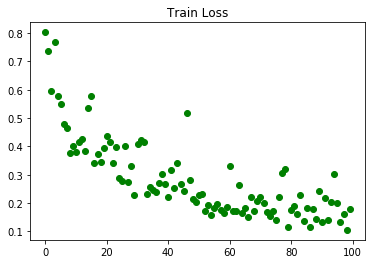

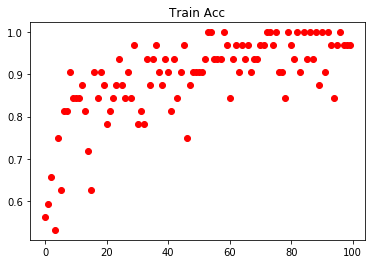

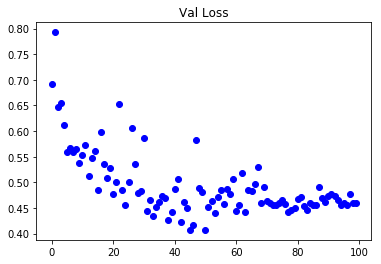

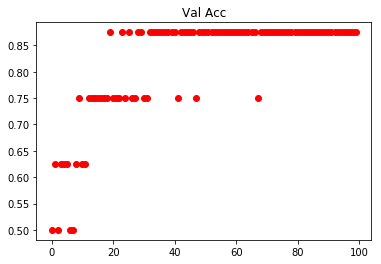

In [211]:
for x in range(0, num_epochs):
    plt.figure(0)
    plt.plot(x, train_loss[x], 'go-')
    plt.title('Train Loss')
    plt.figure(1)
    plt.plot(x, train_acc[x], 'ro')
    plt.title('Train Acc')
    plt.figure(2)
    plt.plot(x, val_loss[x], 'bo')
    plt.title('Val Loss')
    plt.figure(3)
    plt.plot(x, val_acc[x], 'ro')
    plt.title('Val Acc')    

In [212]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [213]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [214]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [215]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)



  0%|          | 0/93 [00:00<?, ?it/s]

  3%|▎         | 3/93 [00:00<00:04, 20.80it/s]

  6%|▋         | 6/93 [00:00<00:04, 20.97it/s]

 10%|▉         | 9/93 [00:00<00:03, 21.11it/s]

 13%|█▎        | 12/93 [00:00<00:03, 21.12it/s]

 16%|█▌        | 15/93 [00:00<00:03, 21.17it/s]

 19%|█▉        | 18/93 [00:00<00:03, 20.95it/s]

 23%|██▎       | 21/93 [00:00<00:03, 21.02it/s]

 26%|██▌       | 24/93 [00:01<00:03, 21.39it/s]

 29%|██▉       | 27/93 [00:01<00:03, 21.36it/s]

 32%|███▏      | 30/93 [00:01<00:02, 21.39it/s]

 35%|███▌      | 33/93 [00:01<00:02, 20.93it/s]

 39%|███▊      | 36/93 [00:01<00:02, 20.95it/s]

 42%|████▏     | 39/93 [00:01<00:02, 21.03it/s]

 45%|████▌     | 42/93 [00:01<00:02, 21.11it/s]

 48%|████▊     | 45/93 [00:02<00:02, 21.35it/s]

 52%|█████▏    | 48/93 [00:02<00:02, 21.38it/s]

 55%|█████▍    | 51/93 [00:02<00:01, 21.43it/s]

 58%|█████▊    | 54/93 [00:02<00:01, 21.47it/s]

 61%|██████▏   | 57/93 [00:02<00:01, 21.47it/s]

 65%|██████▍   | 60/93 [00:02<

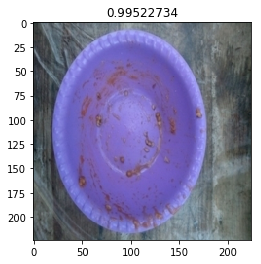

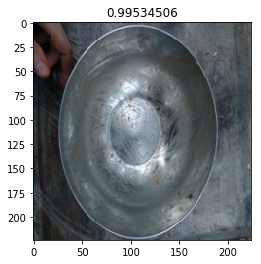

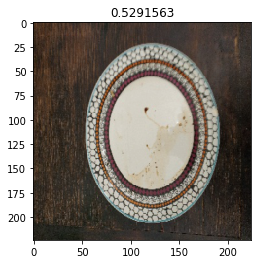

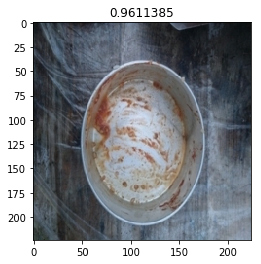

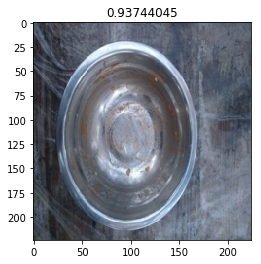

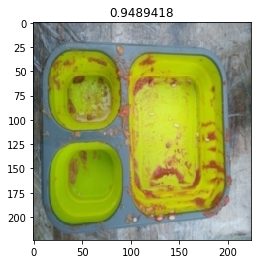

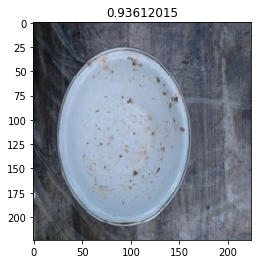

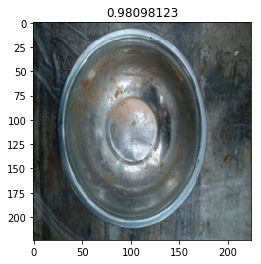

In [216]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [217]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [218]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.9 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [219]:
submission_df.to_csv('submission.csv')

In [220]:
!rm -rf train val test